Factor Analysis

In [14]:
# import libraries
import pandas as pd
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt

In [75]:
# import data
input_file = "case_study_1_michigan_suburban.csv"
df = pd.read_csv(input_file, header=None, sep=",")

# assign headers
df.columns = ['control point 1', 'control point 2', 'control point 3', 'sill height', 'head height', '% opaque panels', 
       'building rotation','south VT', 'south u-value', 'south SHGC', 'east VT', 'east u-value','east SHGC', 'north VT',
              'north u-value', 'north SHGC', 'west VT', 'west u-value', 'west SHGC', 'heating', 'cooling', 'lighting', 'constraint', 'EUI',
              'SF', 'v26','v27']

# dropping unnecessary columns
df.drop(['heating', 'cooling', 'lighting', 'constraint', 'EUI', 'SF','v26','v27'],axis=1,inplace=True)

# show info on dataframe
#df.info()

# display datframe with headers
df.head()

# compute the minimum value per feature on the dataset
min_on_dataset = df.min(axis=0)

# compute the range of each feature (max - min) on the training set
range_on_dataset = (df - min_on_dataset).max(axis=0)

# subtract the min, and divide by range
# afterward, min=0 and max=1 for each feature
df_scaled = (df - min_on_dataset) / range_on_dataset

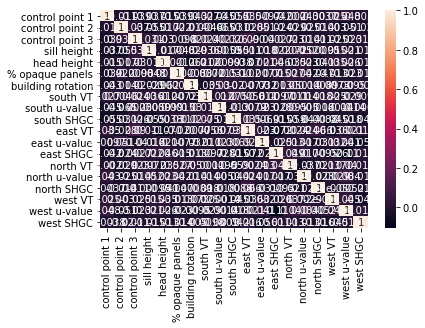

In [76]:
# quick check for dependencies
import seaborn as sn
import matplotlib.pyplot as plt
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [77]:
# check if any columns are linearly dependent (prints rows that are independent)
import sympy 
import numpy as np
df_new = df.round(decimals=3, out=None)
_, inds = sympy.Matrix(df_new).T.rref()
inds

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18)

In [17]:
# Bartlett's Test
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(df)
chi_square_value, p_value

(190.15250275117964, 0.01176283879739755)

In [28]:
# Kaiser-Meyer-Olkin (KMO) Test
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(df_new)
kmo_model

C:\Users\laura\anaconda3\lib\site-packages\factor_analyzer\utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


0.48536557803685826

In [21]:
fa = FactorAnalyzer(rotation=None)
fa.fit(df)
fa.loadings_
fa.get_communalities()

array([0.03002039, 0.04575337, 0.03764725, 0.05118489, 0.02521113,
       0.00648971, 0.00402519, 0.00263418, 0.00201028, 0.03473677,
       0.195581  , 0.02911618, 0.12268552, 0.0135149 , 0.04429243,
       0.02084767, 0.02838915, 0.15550318, 0.00906458])

Random Forest

In [32]:
import mglearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.svm import SVC

In [117]:
input_file = "case_study_1_michigan_suburban.csv"
df = pd.read_csv(input_file, header=None, sep=",")
df.columns = ['control point 1', 'control point 2', 'control point 3', 'sill height', 'head height', '% opaque panels', 
       'building rotation','south VT', 'south u-value', 'south SHGC', 'east VT', 'east u-value','east SHGC', 'north VT',
              'north u-value', 'north SHGC', 'west VT', 'west u-value', 'west SHGC', 'heating', 'cooling', 'lighting', 'constraint', 'EUI',
              'SF', 'v26','v27']
X, y = df.iloc[:, :-8], df.iloc[:, -4]
#print(X)
#print(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

# compute the minimum value per feature on the training set
min_on_training = X_train.min(axis=0)
# compute the range of each feature (max - min) on the training set
range_on_training = (X_train - min_on_training).max(axis=0)

# subtract the min, and divide by range
# afterward, min=0 and max=1 for each feature
X_train_scaled = (X_train - min_on_training) / range_on_training
#print("Minimum for each feature\n", X_train_scaled.min(axis=0))
#print("Maximum for each feature\n", X_train_scaled.max(axis=0))

# use THE SAME transformation on the test set,
# using min and range of the training set 
X_test_scaled = (X_test - min_on_training) / range_on_training

forest = RandomForestRegressor(n_estimators=100, random_state=2)
forest.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(
        forest.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test_scaled, y_test)))

Accuracy on training set: 0.979
Accuracy on test set: 0.872


In [148]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler


# Perform Grid-Search
gsc = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid={'max_depth': (3,4,5,6,7),'n_estimators': (10, 50, 100, 500, 1000)},
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=0, 
    n_jobs=-1)

grid_result = gsc.fit(X, y)
print(grid_result)
best_params = grid_result.best_params_

rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], random_state=False, verbose=False)
# Perform K-Fold CV
scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_absolute_error')

print(best_params)
print(scores)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': (3, 4, 5, 6, 7),
                         'n_estimators': (10, 50, 100, 500, 1000)},
             scoring='neg_mean_squared_error')
{'max_depth': 7, 'n_estimators': 1000}
[-12259171.62057015 -10288743.31072412 -13652056.9875728
 -15846758.22563339 -10607237.71721819 -10604974.42255151
 -13168941.12159982 -13759079.5411103  -13020651.00131182
 -12157251.53493595]


In [149]:
results = pd.DataFrame(grid_result.cv_results_)
display(results.head())

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.055451      0.002999         0.004388        0.000798   
1       0.231780      0.008844         0.007580        0.000489   
2       0.425662      0.005255         0.011170        0.000977   
3       2.030770      0.031717         0.043683        0.001466   
4       4.031620      0.012402         0.090159        0.004259   

  param_max_depth param_n_estimators                                  params  \
0               3                 10    {'max_depth': 3, 'n_estimators': 10}   
1               3                 50    {'max_depth': 3, 'n_estimators': 50}   
2               3                100   {'max_depth': 3, 'n_estimators': 100}   
3               3                500   {'max_depth': 3, 'n_estimators': 500}   
4               3               1000  {'max_depth': 3, 'n_estimators': 1000}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0      -6.595163e+14      -9.098972e+14      -4.661758e+14      -6.187044e+14   
1      -6.342375e+14      -8.923915e+14      -4.313165e+14      -6.538857e+14   
2      -6.190987e+14      -9.042166e+14      -4.241090e+14      -6.381429e+14   
3      -6.175482e+14      -8.699556e+14      -4.247743e+14      -6.481082e+14   
4      -6.166734e+14      -8.898254e+14      -4.254143e+14      -6.405686e+14   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
0      -6.772912e+14    -6.663170e+14    1.427035e+14               25  
1      -6.170418e+14    -6.457746e+14    1.468582e+14               24  
2      -6.320955e+14    -6.435325e+14    1.528789e+14               23  
3      -6.265404e+14    -6.373853e+14    1.413637e+14               21  
4      -6.227141e+14    -6.390392e+14    1.478502e+14               22

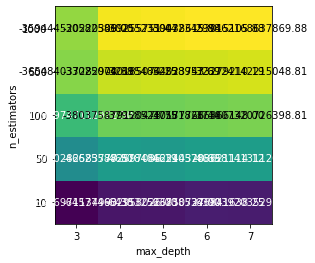

In [151]:
scores = np.array(results.mean_test_score).reshape(5, 5)

mglearn.tools.heatmap(scores, xlabel='max_depth', xticklabels=['3','4','5','6','7'],
                      ylabel='n_estimators', yticklabels=['10','50','100','500','1000'], cmap="viridis")

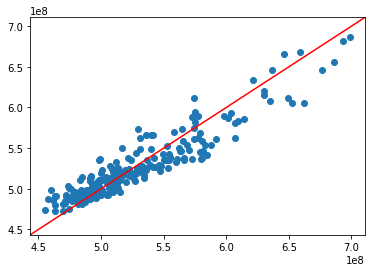

In [145]:
import matplotlib.pyplot as plt
import openpyxl as pyxl
import matplotlib.lines as mlines

predict1 = forest.predict(X_test_scaled)

# plot actual v. predicted
fig, ax = plt.subplots()
ax.scatter(y_test, predict1)
x0,x1 = ax.get_xlim()
ax.set_ylim(x0,x1)
line = mlines.Line2D([0,1], [0,1], color = 'red')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
plt.show()

Feature ranking:
1. feature 5 (0.403825)
2. feature 8 (0.234647)
3. feature 4 (0.132939)
4. feature 14 (0.109908)
5. feature 15 (0.014389)
6. feature 11 (0.014041)
7. feature 9 (0.012991)
8. feature 17 (0.008596)
9. feature 16 (0.008455)
10. feature 3 (0.006864)
11. feature 13 (0.006732)
12. feature 12 (0.006690)
13. feature 0 (0.006597)
14. feature 18 (0.006273)
15. feature 2 (0.006270)
16. feature 7 (0.006053)
17. feature 6 (0.005229)
18. feature 1 (0.004938)
19. feature 10 (0.004565)


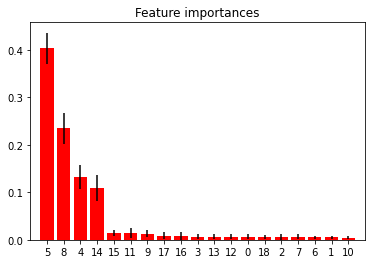

In [37]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

Feature 5 is % opaque panels, feature 8 is south u-value, feature 4 is head height, feature 14 is north u-value

In [154]:
input_file = "case_study_2_texas_urban.csv"
df = pd.read_csv(input_file, header=None, sep=",")
X, y = df.iloc[:, :-7], df.iloc[:, -7]
#print(X)
#print(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
forest = RandomForestRegressor(n_estimators=500, random_state=1)
forest.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

FileNotFoundError: [Errno 2] File case_study_2_texas_urban.csv does not exist: 'case_study_2_texas_urban.csv'

In [ ]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

Feature 7 is % opaque panels, feature 6 is head height

PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
print(principalDf)

In [ ]:
plt.scatter(finalDf.iloc[:, 0], finalDf.iloc[:, 1])
plt.xlabel('component 1')
plt.ylabel('component 2')

Feature ranking:
1. feature 7 (0.513919)
2. feature 6 (0.225590)
3. feature 18 (0.041232)
4. feature 12 (0.030743)
5. feature 21 (0.023974)
6. feature 15 (0.018198)
7. feature 5 (0.017646)
8. feature 0 (0.014700)
9. feature 22 (0.011294)
10. feature 13 (0.010011)
11. feature 14 (0.009076)
12. feature 9 (0.009049)
13. feature 16 (0.008903)
14. feature 19 (0.008832)
15. feature 11 (0.008030)
16. feature 1 (0.007141)
17. feature 17 (0.007046)
18. feature 10 (0.006653)
19. feature 8 (0.006021)
20. feature 2 (0.005838)
21. feature 4 (0.005779)
22. feature 20 (0.005604)
23. feature 3 (0.004720)


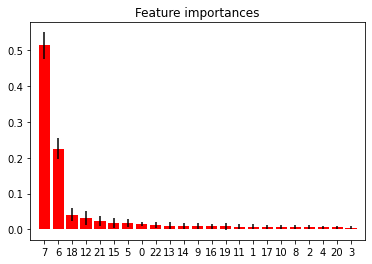

Feature 7 is % opaque panels, feature 6 is head height

PCA

In [152]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
print(principalDf)

     principal component 1  principal component 2
0                 0.710370               0.031360
1                -0.301039              -0.417182
2                 0.034512               0.354474
3                 0.230978               0.067564
4                -0.364831               0.163717
..                     ...                    ...
745               0.196712              -0.207609
746              -0.263121               0.015559
747               0.391404              -0.380753
748               0.266901              -0.093472
749               0.320790              -0.328085

[750 rows x 2 columns]


Text(0, 0.5, 'component 2')

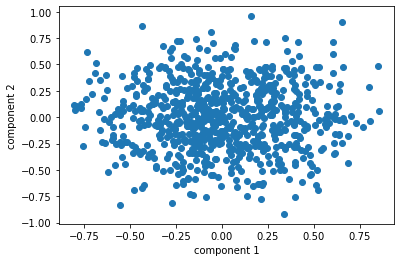

In [153]:
plt.scatter(finalDf.iloc[:, 0], finalDf.iloc[:, 1])
plt.xlabel('component 1')
plt.ylabel('component 2')